In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def load_images_and_masks(data_path, img_size=(512, 512)):
    images = []
    masks = []

    all_files = sorted(os.listdir(data_path))
    image_files = [f for f in all_files if 'sat' in f and f.endswith('.jpg')]
    mask_files = {f.replace('_mask.png', ''): f for f in all_files if 'mask' in f and f.endswith('.png')}

    for img_file in image_files:
        image = cv2.imread(os.path.join(data_path, img_file))
        image = cv2.resize(image, img_size)
        image = image.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(image)

        base_filename = img_file.replace('_sat.jpg', '')
        if base_filename in mask_files:
            mask_file = mask_files[base_filename]
            mask = cv2.imread(os.path.join(data_path, mask_file), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = (mask > 128).astype(np.uint8)
            masks.append(mask)

    return np.array(images), np.array(masks)

data_path = '/content/drive/MyDrive/Linear_Feature_Extraction_Dataset/train'
images, masks = load_images_and_masks(data_path)
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_masks = train_masks.astype('float32')
val_masks = val_masks.astype('float32')

In [2]:
print(train_images.shape)
print(train_masks.shape)

(201, 512, 512, 3)
(201, 512, 512)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(512, 512, 3)):
    inputs = Input(input_size)

    def conv_block(x, filters):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    # Encoder
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)

    # Bottleneck
    c5 = conv_block(p4, 256)

    # Decoder
    d4 = decoder_block(c5, c4, 128)
    d3 = decoder_block(d4, c3, 64)
    d2 = decoder_block(d3, c2, 32)
    d1 = decoder_block(d2, c1, 16)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d1)

    model = Model(inputs, outputs)
    return model

# Create the model
model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['batch_normalization[0][0

In [1]:
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def combined_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)

In [7]:
# model = unet_model()
model.compile(optimizer=Adam(lr=1e-4), loss=combined_loss, metrics=['accuracy', Precision()])

model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=50, batch_size=4)

Epoch 1/50
51/51 [==============================] - 49s 380ms/step - loss: 1.5640 - accuracy: 0.6976 - precision: 0.0728 - val_loss: 1.7845 - val_accuracy: 0.2184 - val_precision: 0.0479
Epoch 2/50
51/51 [==============================] - 9s 172ms/step - loss: 1.4096 - accuracy: 0.8521 - precision: 0.1283 - val_loss: 1.3342 - val_accuracy: 0.9543 - val_precision: 0.0073
Epoch 3/50
51/51 [==============================] - 9s 175ms/step - loss: 1.2881 - accuracy: 0.9104 - precision: 0.1668 - val_loss: 1.1603 - val_accuracy: 0.9536 - val_precision: 0.0609
Epoch 4/50
51/51 [==============================] - 9s 176ms/step - loss: 1.1838 - accuracy: 0.9271 - precision: 0.2016 - val_loss: 1.1327 - val_accuracy: 0.9542 - val_precision: 0.1246
Epoch 5/50
51/51 [==============================] - 9s 176ms/step - loss: 1.0861 - accuracy: 0.9331 - precision: 0.2553 - val_loss: 1.1248 - val_accuracy: 0.9293 - val_precision: 0.2397
Epoch 6/50
51/51 [==============================] - 9s 178ms/step - l

In [8]:
# # Save the model to Google Drive
# model.save('/content/drive/MyDrive/Linear_Feature_Extraction_Dataset/road_network_extraction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision

# Load the model
model = load_model('/content/drive/MyDrive/Linear_Feature_Extraction_Dataset/road_network_extraction_model.h5', custom_objects={'combined_loss': combined_loss, 'dice_loss': dice_loss, 'Precision': Precision()})

1/1 [==============================] - 2s 2s/step


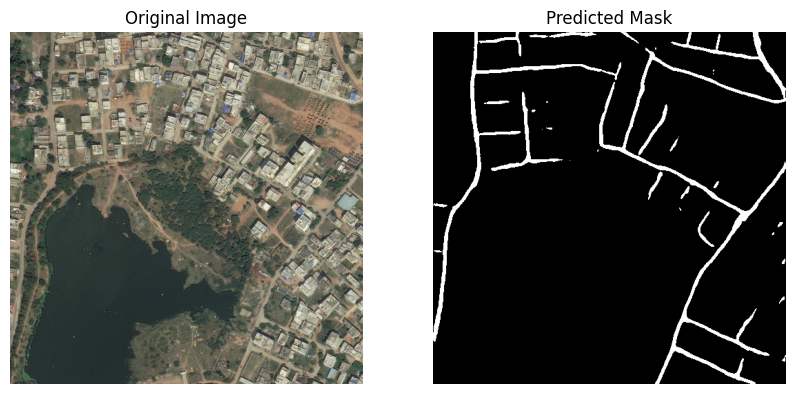

In [4]:
# Function to load and preprocess a single image
import cv2
import numpy as np
def load_and_preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Load an example image for prediction
image_path = '/content/drive/MyDrive/Linear_Feature_Extraction_Dataset/test/999651_sat.jpg'
input_image = load_and_preprocess_image(image_path)

# Make predictions
predictions = model.predict(input_image)

# Binarize the predictions
predicted_mask = (predictions[0] > 0.5).astype(np.uint8)  # Thresholding

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()